In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.variational.double_stochastic import DoubleStochastic
from mcjax.proba.gaussian import Gauss
from mcjax.proba.banana2d import Banana2D


In [2]:
# initialize PRNG
key = jr.key(0)

In [3]:
# mu_star = jnp.array([1., 1.])
# cov_star = jnp.array([[1., 0.97], [0.97, 1.]])
# dist = Gauss(mu=mu_star, cov=0.1*cov_star)
dist = Banana2D(noise_std=0.2)

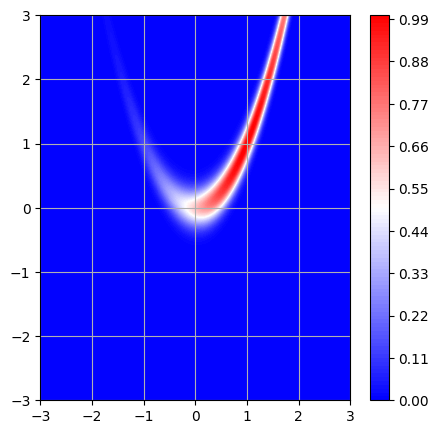

In [4]:
xmin, xmax = -3, 3
ymin, ymax = -3, 3
N_discr = 500
X, Y = np.meshgrid(np.linspace(xmin, xmax, N_discr), np.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_flat = dist.batch(jnp.array([X_flat, Y_flat]).T)
Z = Z_flat.reshape(X.shape)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.grid()


In [5]:
approx = DoubleStochastic(logtarget=dist)

In [6]:
key, key_ = jr.split(key)
n_samples = 1000
n_iter  = 5_000
verbose = False
store_params_trace = True
adam_lr = 0.01
use_jit = True

# run mean_field
approx_type = 'diag'
mu_init = jnp.array([0., 2.])
cov_init = jnp.eye(2)
run_output_diag = approx.run(key=key_, n_samples=n_samples,
                        mu_init=mu_init, cov_init=cov_init,
                        n_iter=n_iter, verbose=verbose, store_params_trace=store_params_trace,
                        adam_lr=adam_lr, use_jit=use_jit,
                        approx_type=approx_type)

# # run full gaussian
approx_type = 'full'
mu_init = jnp.array([0., 2.])
cov_init = jnp.eye(2)
run_output_full = approx.run(key=key_, n_samples=n_samples,
                             mu_init=mu_init, cov_init=cov_init,
                             n_iter=n_iter, verbose=verbose, store_params_trace=store_params_trace,
                             adam_lr=adam_lr, use_jit=use_jit,
                             approx_type=approx_type)

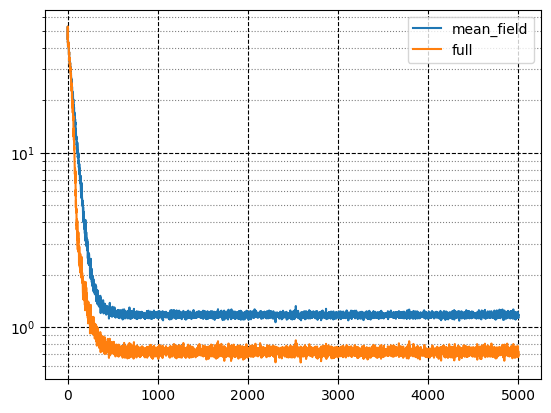

In [7]:
plt.plot( np.array(run_output_diag["kl_trace"]), label="mean_field")
plt.plot( np.array(run_output_full["kl_trace"]), label="full")
plt.yscale('log')
plt.grid(which="major", linestyle="--", color="black", alpha=1)
plt.grid(which="minor", linestyle=":", color="black", alpha=0.5)
plt.legend()

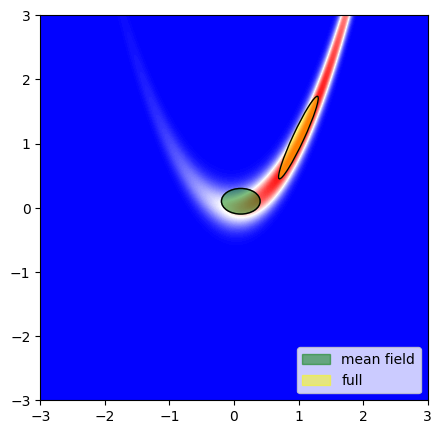

In [8]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')


outputs = [run_output_diag, run_output_full]
output_type = ["mean field", "full"]
output_color = ["green", "yellow"]
for index, run_output in enumerate(outputs):
    # plot the final approximation
    it = -1
    if run_output["approx_type"] == "diag":
        mu = run_output["params_trace"][it]["mu"]
        log_stds = run_output["params_trace"][it]["log_std"]
        cov = jnp.diag(jnp.exp(2*log_stds))
    elif run_output["approx_type"] == "full":
        mu = run_output["params_trace"][it]["mu"]
        J = run_output["params_trace"][it]["cov_chol"]
        cov = J @ J.T


    #plt.subplot(1, 2, index+1)
    # draw the ellipse associated to the Gaussian N(mu, cov)
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    angle = 180 * angle / jnp.pi
    # fill the ellipse with color yellow
    ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                  angle=angle, color=output_color[index],
                  alpha=0.5, label=output_type[index])
    ax.add_artist(ell)
    # draw another ellipse, but with only the edge in black
    ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                    angle=angle, edgecolor='black', fill=False, 
                    linewidth=1)
    # add a star at the center of the ellipse
    # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
    ax.add_artist(ell_edge)
    
plt.legend(loc='lower right')

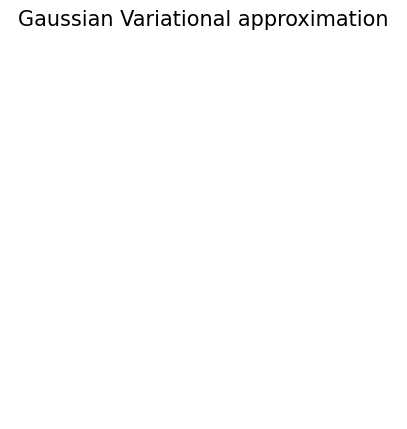

In [9]:
# create animation with celluloid
from celluloid import Camera
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5, 5))

# create camera
camera = Camera(fig)

# create a list of iterations to plot
nframes = 100
it_list = np.linspace(0, 500, nframes).astype(int)

first_time = True
for it in it_list:
    ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
    outputs = [run_output_diag, run_output_full]
    output_type = ["mean field", "full"]
    output_color = ["green", "yellow"]
    for index, run_output in enumerate(outputs):
        # plot the final approximation
        if run_output["approx_type"] == "diag":
            mu = run_output["params_trace"][it]["mu"]
            log_stds = run_output["params_trace"][it]["log_std"]
            cov = jnp.diag(jnp.exp(2*log_stds))
        elif run_output["approx_type"] == "full":
            mu = run_output["params_trace"][it]["mu"]
            J = run_output["params_trace"][it]["cov_chol"]
            cov = J @ J.T


        #plt.subplot(1, 2, index+1)
        # draw the ellipse associated to the Gaussian N(mu, cov)
        eigvals, eigvecs = jnp.linalg.eigh(cov)
        angle = jnp.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        angle = 180 * angle / jnp.pi
        # fill the ellipse with color yellow
        ell = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]),
                    angle=angle, color=output_color[index],
                    alpha=0.5, label=output_type[index])
        ax.add_artist(ell)
        # draw another ellipse, but with only the edge in black
        ell_edge = Ellipse(xy=mu, width=2*jnp.sqrt(eigvals[0]), height=2*jnp.sqrt(eigvals[1]), 
                        angle=angle, edgecolor='black', fill=False, 
                        linewidth=1)
        # add a star at the center of the ellipse
        # ax.plot(mu[0], mu[1], marker='*', color='black', markersize=10)
        ax.add_artist(ell_edge)
        
    # do not display axis
    ax.axis('off')
        
    # add legend
    if first_time:
        first_time = False
        ax.legend(loc='lower right')
        # add title
        ax.set_title("Gaussian Variational approximation", fontsize=15)
    
    # snap the current plot
    camera.snap()
    
# create animation
animation = camera.animate()

In [10]:
# display animation
HTML(animation.to_html5_video())

In [11]:
# save the video in mp4
animation.save('gaussian_variational_approximation.mp4', fps=10, dpi=300)